Planning path...
Path planned.
Plotting path...


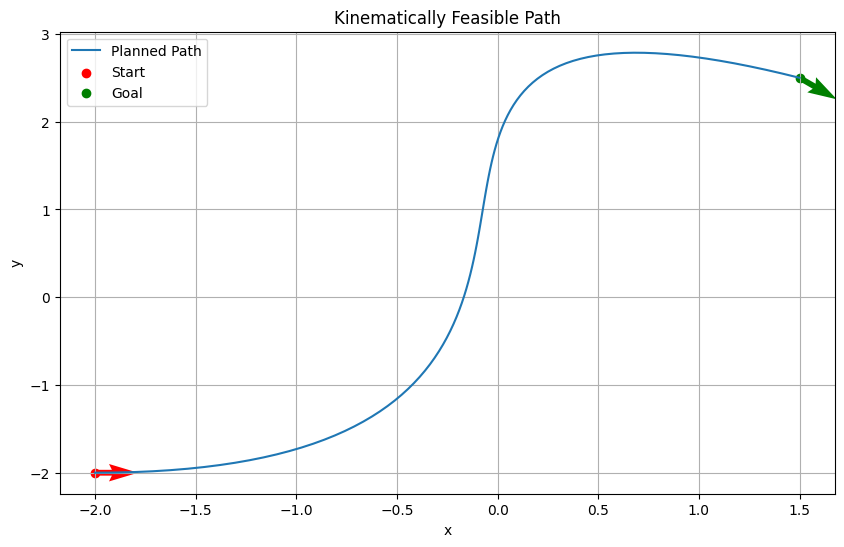

Path plotted.
Initializing simulator...


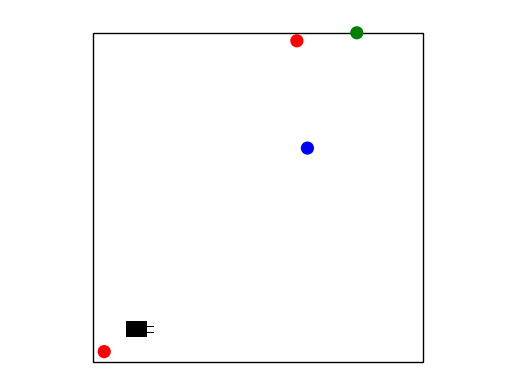

Simulator initialized.
Executing path in simulator...
Step 1/100: Setting v = 1.0000, omega = 0.3700
Robot pose: [-1.997, -2.0, 0.0111]


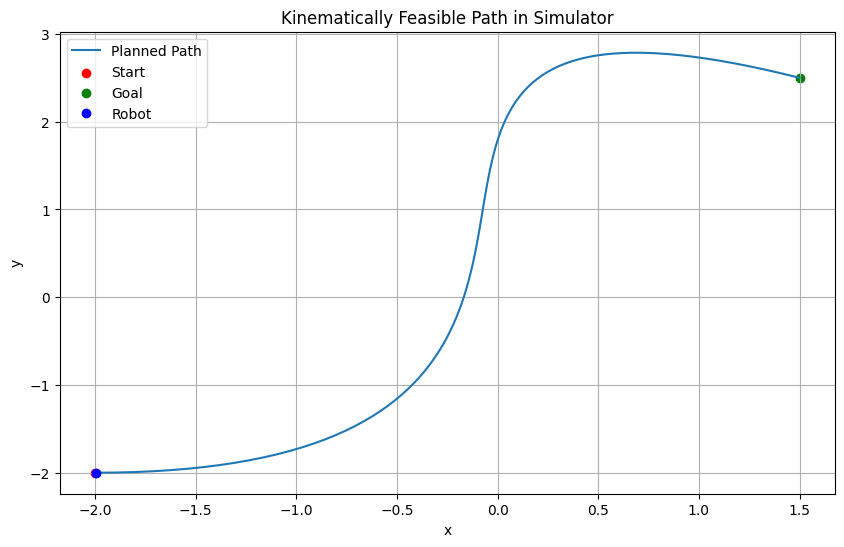

Step 2/100: Setting v = 0.9644, omega = 0.3887
Robot pose: [-1.9745013860982683, -1.9997502551285846, 0.09856680099421364]
Step 3/100: Setting v = 0.9309, omega = 0.4075
Robot pose: [-1.9639528361187393, -1.9987071380069836, 0.14175918638838683]
Step 4/100: Setting v = 0.8997, omega = 0.4259
Robot pose: [-1.9533601680138768, -1.9971953898731243, 0.18733286665540863]
Step 5/100: Setting v = 0.8707, omega = 0.4438
Robot pose: [-1.9428473703605114, -1.9952026316089602, 0.23481476314911198]
Step 6/100: Setting v = 0.8441, omega = 0.4606
Robot pose: [-1.9327327728207218, -1.9927829381143034, 0.2827182488129951]
Step 7/100: Setting v = 0.8198, omega = 0.4761
Robot pose: [-1.9225535855569196, -1.989825887785268, 0.33318378016518146]
Step 8/100: Setting v = 0.7978, omega = 0.4898
Robot pose: [-1.9129145256956641, -1.986489943392576, 0.3831419546664806]
Step 9/100: Setting v = 0.7783, omega = 0.5013
Robot pose: [-1.9029903330651536, -1.9824898933138244, 0.43678089231049666]
Step 10/100: Setting

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from mobile_manipulator_unicycle_sim import MobileManipulatorUnicycleSim

# Define the state feedback controller
def state_feedback_controller(KP, KD, zd, z, zd_dot, z_dot):
    return KP * (zd - z) + KD * (zd_dot - z_dot)

# Define the initial and final positions and orientations
start_pos = np.array([-2, -2])
start_theta = 0

# Define the time vector
t = np.linspace(0, 10, 100)

# Define the boundary conditions for cubic spline interpolation
# Position boundary conditions
pos_x = [start_pos[0], 1.5]
pos_y = [start_pos[1], 2.5]

# Derivative boundary conditions (initial and final orientations)
dx_dt = [np.cos(start_theta), np.cos(-np.pi / 6)]
dy_dt = [np.sin(start_theta), np.sin(-np.pi / 6)]

# Create cubic splines for x and y positions
cs_x = CubicSpline([0, 10], pos_x, bc_type=((1, dx_dt[0]), (1, dx_dt[1])))
cs_y = CubicSpline([0, 10], pos_y, bc_type=((1, dy_dt[0]), (1, dy_dt[1])))

# Controller gains
KP = 5.0
KD = 0.5

# Initialize the simulator with fixed positions and obstacles just outside the environment
env_size = 7
obstacle_offset = 0.1
robot = MobileManipulatorUnicycleSim(
    robot_id=1,
    robot_pose=[-2.0, -2.0, 0.0],
    pickup_location=[-2.0, -2.0],
    dropoff_location=[1.5, 2.5],
    obstacles_location=[[env_size / 2 + obstacle_offset, env_size / 2 + obstacle_offset],
                        [-env_size / 2 - obstacle_offset, -env_size / 2 - obstacle_offset]]  # Obstacles just outside the environment
)

# Draw initial conditions from a normal distribution
w0 = np.random.normal(loc=[start_pos[0], start_pos[1], 0, 0], scale=0.1, size=(4,))
robot.robot_pose = w0[:3]  # Initialize the robot's pose
z = w0[:2]
z_dot = w0[2:]

trajectory = [z.copy()]

for ti in t:
    zd = np.array([cs_x(ti), cs_y(ti)])
    zd_dot = np.array([cs_x.derivative()(ti), cs_y.derivative()(ti)])

    uw = state_feedback_controller(KP, KD, zd, z, zd_dot, z_dot)

    # Compute the control inputs based on the desired trajectory
    v_t = np.sqrt(zd_dot[0]**2 + zd_dot[1]**2)
    omega_t = (cs_y.derivative(2)(ti) * cs_x.derivative()(ti) - cs_x.derivative(2)(ti) * cs_y.derivative()(ti)) / (cs_x.derivative()(ti)**2 + cs_y.derivative()(ti)**2)

    # Apply the control inputs to the robot
    robot.set_mobile_base_speed_and_gripper_power(v_t, omega_t, 0.0)

    # Simulate the robot's movement (assume a simple kinematic model for this example)
    dt = t[1] - t[0]
    robot.robot_pose[0] += v_t * np.cos(robot.robot_pose[2]) * dt
    robot.robot_pose[1] += v_t * np.sin(robot.robot_pose[2]) * dt
    robot.robot_pose[2] += omega_t * dt

    z = robot.robot_pose[:2]
    z_dot = np.array([v_t * np.cos(robot.robot_pose[2]), v_t * np.sin(robot.robot_pose[2])])

    trajectory.append(z.copy())

trajectory = np.array(trajectory)

# Plot the trajectory
plt.figure()
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title(f'Trajectory (KP={KP}, KD={KD})')
plt.show()